## Disinfo scrape

In [ ]:
import pandas as pd
from datetime import datetime
import requests
import time
from bs4 import BeautifulSoup

# Milyen oszlopok legyenek/lesznek az adatbátzisban?
columns = ['title', 'author', 'url', 'date', 'year', 'month', 'day', 'regions', 'tags', 'summary', 'og_link', 'original_lang', 'label'] # site_html, article_text_en, media_links



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df_fake = pd.read_csv('/content/drive/MyDrive/Fake news project/fake.csv') # read the existing dataset if there is one

In [ ]:
df_fake

,title,author,url,date,year,month,day,regions,tags,summary,og_link,original_lang,label,tags_list
0,White House admits there is no evidence of Rus...,na,https://euvsdisinfo.eu/report/white-house-admi...,2024-02-26,2024,2,26,"US, Russia","election meddling, Manipulated elections/refer...",The White House admits there is no evidence of...,https://sputniknews.lat/20240226/la-casa-blanc...,Spanish,1,"['election meddling', ' Manipulated elections/..."
1,Russian defector killed in Spain may have been...,na,https://euvsdisinfo.eu/report/russian-defector...,2024-02-26,2024,2,26,"Spain, Ukraine, Russia","Invasion of Ukraine, Intelligence services, Se...","According to Spanish media, the traitor Maxim ...",https://t.me/infodefSPAIN/11577,Russian,1,"['Invasion of Ukraine', ' Intelligence service..."
2,Afghanistan is part of the West’s geopolitical...,na,https://euvsdisinfo.eu/report/afghanistan-is-p...,2024-02-25,2024,2,25,"Afghanistan, US","NATO, Jihad, Islamic extremism",Afghanistan is one link in the chain of endles...,https://russianskz.info/politics/14253-agentur...,Russian,1,"['NATO', ' Jihad', ' Islamic extremism']"
3,Crimea and Sevastopol are an integral part of ...,na,https://euvsdisinfo.eu/report/crimea-and-sevas...,2024-02-25,2024,2,25,Russia,"Crimea, Vladimir Putin, illegal annexation, Re...","On March 16, 2014, a referendum began in Crime...",https://www.iravunk.com/?p=277195&l=am,Armenian,1,"['Crimea', ' Vladimir Putin', ' illegal annexa..."
4,The Soviet Union fought Nazism alone,na,https://euvsdisinfo.eu/report/the-soviet-union...,2024-02-23,2024,2,23,"Germany, France, Russia","Donald Trump, WWII, Adolf Hitler, Nazi/Fascist...",Europeans don’t agree that the Soviet Union al...,https://t.me/s/kornilov1968,"Russian, French",1,"['Donald Trump', ' WWII', ' Adolf Hitler', ' N..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10162,Warsaw rewriting WWII history for propaganda p...,na,https://euvsdisinfo.eu/report/warsaw-rewriting...,2020-01-22,2020,1,22,"USSR, Poland, Germany, Russia","World War 2, Historical revisionism, Red Army,...","600,000 Soviet soldiers died in the liberation...",https://www.rt.com/news/478844-polish-nazis-ho...,English,1,"['World War 2', ' Historical revisionism', ' R..."
10163,A new Chinese coronavirus was likely elaborate...,na,https://euvsdisinfo.eu/report/a-new-chinese-co...,2020-01-22,2020,1,22,"China, US","coronavirus, Virus / bacteria threat, European...","Global fights are not ethical, everything can ...",https://sputnik.by/video/20200122/1043758449/N...,Russian,1,"['coronavirus', ' Virus / bacteria threat', ' ..."
10164,"Over 80,000 people froze to death in the US du...",na,https://euvsdisinfo.eu/report/over-80000-peopl...,2020-01-22,2020,1,22,US,fake statistics,There is a big difference between how many peo...,https://sputnik.by/video/20200122/1043758449/N...,Russian,1,['fake statistics']
10165,"Hungary, Lithuania and Poland distort their Ho...",na,https://euvsdisinfo.eu/report/hungary-lithuani...,2020-01-21,2020,1,21,"Hungary, Poland, Lithuania",Anti-Semitism,A number of governments distort their countrie...,https://www.strategic-culture.org/news/2020/01...,English,1,['Anti-Semitism']


In [ ]:
from re import I

end_page = 50 #egyes batchekben hány oldalnyi cikket szedjen le (leginkább azért kell, hogy, ha valahol elszáll, ne előről kelljen kezdeni)
content = ""

db_url = "https://euvsdisinfo.eu/disinformation-cases" # https://euvsdisinfo.eu/disinformation-cases/page/3/
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

def get_urls(url): #10 link per page through multiple page -> these are the summaries of the articles
  # The URL of the page with the list of disinformation cases
  response = requests.get(url, headers=headers)
  #print(response.text)
  soup = BeautifulSoup(response.text, 'html.parser')
  # Find links to individual disinformation cases
  # Assuming each case is linked using <a> tags within divs of a specific class
  case_links = soup.find_all('a', class_ = 'b-archive__database-item')

  return case_links

def get_data(url, start_page):
    df_fake_temp = pd.DataFrame(columns=columns)
    page = start_page

    while page <= (start_page + end_page):

        try:
            time.sleep(5)  # Be polite and don't hammer the server
            if page == 1:
                case_links = get_urls(url)
            else:
                url_ = f"{url}/page/{page}/"
                #print(url_)
                case_links = get_urls(url_)




            for link in case_links:
                time.sleep(1)
                # Safety net for missing href attributes
                case_url = link.get('href', "")

                if case_url:
                    case_url = "https://euvsdisinfo.eu" + case_url
                    print(case_url)
                    try:
                        case_response = requests.get(case_url, headers=headers) #getting each article
                        case_soup = BeautifulSoup(case_response.text, 'html.parser')
                        #print(case_soup)
                        #------------------------------------------------------------------------
                        title_element = case_soup.find('h1', class_='b-report__title')
                        title_ = title_element.text.strip() if title_element else 'Title not found'
                        title_words = title_.split()[1:] # remove the first word ('DISINFO:')
                        title = ' '.join(title_words)
                        #print(title)
                        target_div = case_soup.select_one('div.b-report__summary > div.b-text')

                        if target_div:
                            paragraph_texts = []

                            # Iterate over each 'p' tag within the div
                            for paragraph in target_div.find_all('p'):
                                content = ""
                                # Extract the text from the paragraph tag and add it to the list
                                paragraph_texts.append(paragraph.text)
                                content +=paragraph.text

                        else:
                            content = "Could not find content."





                        target_ul = case_soup.find('ul', class_='b-report__details-list')
                        #print(target_ul)
                        # Find all <li> elements within the <ul> - the extra infomations (original country, date, tags) about the article are in a list, and some of them could be missing
                        if target_ul:
                            list_items = target_ul.find_all('li')

                            if list_items:
                                if len(list_items) > 0:
                                    original_link = list_items[0].find('a')
                                    if original_link:
                                        og_url = original_link.get('href', "")

                                if len(list_items) > 1:
                                    date_span = list_items[1].find('span')
                                    if date_span:
                                        date_text = date_span.text.strip()
                                        try:
                                            date_object = datetime.strptime(date_text, '%B %d, %Y')
                                            # If you just want a date object, not a datetime
                                            date = date_object.date()
                                        except ValueError:
                                            date_text = ""
                                            date = None

                                if len(list_items) > 3:
                                    og_lan_span = list_items[len(list_items)-2].find('span')
                                    if og_lan_span:
                                        og_lan = og_lan_span.text.strip()

                                if list_items:
                                    regions_span = list_items[len(list_items)-1].find('span')
                                    if regions_span:
                                        regions_text = regions_span.text.strip()
                        else:
                            print("Details list not found")


                        tags = case_soup.find('div', class_ = 'b-report__keywords')
                        tags_text = []
                        tags_line = ""
                        for tag_ in tags.find_all('span'):

                            tags_text.append(tag_.text)
                        # Extract the text from the paragraph tag and add it to the list
                            tags_line +=tag_.text + ", "


                        author = "na" # there are no authors presented next to the summaries -> getting the original articles authors are hard, different pages that could be already deleted

                        new_page_data = [title, author, case_url, date, date.year, date.month, date.day, regions_text, tags_line, content, og_url, og_lan, 1] #scraped data in a form that can be added to the Dataframe

                        print(f'Title: {title} \n Date: {date} - URL: {case_url}\n Regions: {regions_text} \n Tags: {tags_line} \n Content: {content} \n \n')

                        df_fake_temp = df_fake_temp.append(pd.Series(new_page_data, index = df_fake_temp.columns), ignore_index = True) # add the article to the dataframe that willl be returned

                       # print(data_list)
                    except Exception as e:
                        print(f"Error loading case page: {e}")
                else:
                    print("No href found for a case link.")

           # df_fake_temp.append(data_list, ignore_index = True)
            #print(df_fake_temp)
            page += 1 # the url contains the paging so I use this to know where the scraping is and to navigate pages
            print(page)
            print("\n")
        except Exception as e:
            print(f"Error processing page {page}: {e}")
    print(df_fake_temp)
    return df_fake_temp

In [ ]:
df_temp = get_data(db_url, 929) # 50-es batchekben: 1 - 51 (509 )> 52 - 102  (1018)> 103 - 153 (1528) > 154 -204 > 205 - 255 > 256 - 306 > 307 - 357 > 358 - 408 > 409 - 459> 460 - 510 > 511 - 561 > 562 - 612 > 613-663> 664-714 > 715 - 775 > 776 - 826 > 827 -877>878 - 928


In [ ]:
df_fake = df_fake.append(df_temp, ignore_index = True) #Adding the current batch to the exsting dataset

NameError: name 'df_temp' is not defined

In [ ]:
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10167 entries, 0 to 10166
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          10167 non-null  object
 1   author         10167 non-null  object
 2   url            10167 non-null  object
 3   date           10167 non-null  object
 4   year           10167 non-null  int64 
 5   month          10167 non-null  int64 
 6   day            10167 non-null  int64 
 7   regions        10167 non-null  object
 8   tags           10167 non-null  object
 9   summary        9934 non-null   object
 10  og_link        10087 non-null  object
 11  original_lang  10167 non-null  object
 12  label          10167 non-null  int64 
 13  tags_list      10167 non-null  object
dtypes: int64(4), object(10)
memory usage: 1.1+ MB


In [ ]:
df_fake['tags'] = df_fake['tags'].apply(lambda x: x.rstrip(', ')) #there is a unnecessary ',' at the end of each line, this deletes that

In [ ]:
df_fake.to_csv('fake.csv') #save df

In [ ]:
df_fake.to_csv('/content/drive/My Drive/Fake news project/fake.csv', index=False) # save df to google drive

In [ ]:
df_fake.isna().sum() #check for empty data, ? -> oldalon ott vannak a summaryk  a hiányzóknál

title              0
author             0
url                0
date               0
year               0
month              0
day                0
regions            0
tags               0
summary          233
og_link           80
original_lang      0
label              0
tags_list          0
dtype: int64

In [ ]:
df_fake

,title,author,url,date,year,month,day,regions,tags,summary,og_link,original_lang,label,tags_list
0,White House admits there is no evidence of Rus...,na,https://euvsdisinfo.eu/report/white-house-admi...,2024-02-26,2024,2,26,"US, Russia","election meddling, Manipulated elections/refer...",The White House admits there is no evidence of...,https://sputniknews.lat/20240226/la-casa-blanc...,Spanish,1,"['election meddling', ' Manipulated elections/..."
1,Russian defector killed in Spain may have been...,na,https://euvsdisinfo.eu/report/russian-defector...,2024-02-26,2024,2,26,"Spain, Ukraine, Russia","Invasion of Ukraine, Intelligence services, Se...","According to Spanish media, the traitor Maxim ...",https://t.me/infodefSPAIN/11577,Russian,1,"['Invasion of Ukraine', ' Intelligence service..."
2,Afghanistan is part of the West’s geopolitical...,na,https://euvsdisinfo.eu/report/afghanistan-is-p...,2024-02-25,2024,2,25,"Afghanistan, US","NATO, Jihad, Islamic extremism",Afghanistan is one link in the chain of endles...,https://russianskz.info/politics/14253-agentur...,Russian,1,"['NATO', ' Jihad', ' Islamic extremism']"
3,Crimea and Sevastopol are an integral part of ...,na,https://euvsdisinfo.eu/report/crimea-and-sevas...,2024-02-25,2024,2,25,Russia,"Crimea, Vladimir Putin, illegal annexation, Re...","On March 16, 2014, a referendum began in Crime...",https://www.iravunk.com/?p=277195&l=am,Armenian,1,"['Crimea', ' Vladimir Putin', ' illegal annexa..."
4,The Soviet Union fought Nazism alone,na,https://euvsdisinfo.eu/report/the-soviet-union...,2024-02-23,2024,2,23,"Germany, France, Russia","Donald Trump, WWII, Adolf Hitler, Nazi/Fascist...",Europeans don’t agree that the Soviet Union al...,https://t.me/s/kornilov1968,"Russian, French",1,"['Donald Trump', ' WWII', ' Adolf Hitler', ' N..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10162,Warsaw rewriting WWII history for propaganda p...,na,https://euvsdisinfo.eu/report/warsaw-rewriting...,2020-01-22,2020,1,22,"USSR, Poland, Germany, Russia","World War 2, Historical revisionism, Red Army,...","600,000 Soviet soldiers died in the liberation...",https://www.rt.com/news/478844-polish-nazis-ho...,English,1,"['World War 2', ' Historical revisionism', ' R..."
10163,A new Chinese coronavirus was likely elaborate...,na,https://euvsdisinfo.eu/report/a-new-chinese-co...,2020-01-22,2020,1,22,"China, US","coronavirus, Virus / bacteria threat, European...","Global fights are not ethical, everything can ...",https://sputnik.by/video/20200122/1043758449/N...,Russian,1,"['coronavirus', ' Virus / bacteria threat', ' ..."
10164,"Over 80,000 people froze to death in the US du...",na,https://euvsdisinfo.eu/report/over-80000-peopl...,2020-01-22,2020,1,22,US,fake statistics,There is a big difference between how many peo...,https://sputnik.by/video/20200122/1043758449/N...,Russian,1,['fake statistics']
10165,"Hungary, Lithuania and Poland distort their Ho...",na,https://euvsdisinfo.eu/report/hungary-lithuani...,2020-01-21,2020,1,21,"Hungary, Poland, Lithuania",Anti-Semitism,A number of governments distort their countrie...,https://www.strategic-culture.org/news/2020/01...,English,1,['Anti-Semitism']


###Analízis az adatokon - tag, language, region

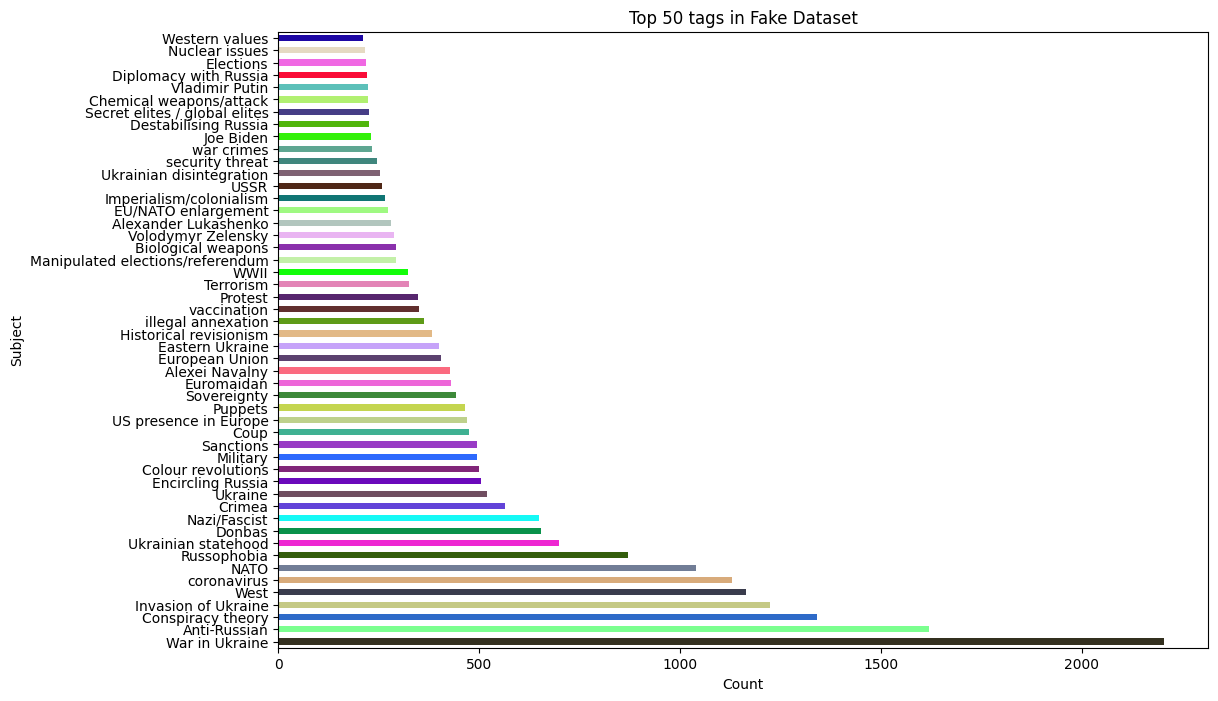

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import nltk
from nltk.corpus import stopwords
import random
#nltk.download('stopwords')


df_fake['tags_list'] = df_fake['tags'].str.split(',')

# Create a flat list of all subjects
tags = [subject.strip() for subjects_list in df_fake['tags_list'] for subject in subjects_list]

# Count the occurrences of each subject
subject_counts = pd.Series(tags).value_counts()
colors =['#%02x%02x%02x' % (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(len(subject_counts))]
# Plot the top N subjects (adjust N as needed)
top_n_subjects = 50
subject_counts.head(top_n_subjects).plot(kind='barh', figsize=(12, 8), color=colors)
plt.title('Top {} tags in Fake Dataset'.format(top_n_subjects))
plt.xlabel('Count')
plt.ylabel('Subject')
plt.show()

In [ ]:
# eredeti df szűrése bizonyos dátumtól
certain_date = pd.to_datetime('2021-01-01')
df_fake['date'] = pd.to_datetime(df_fake['date'])
# Filter the DataFrame to get rows after the certain date
filtered_df = df_fake[df_fake['date'] > certain_date].copy()

In [ ]:
filtered_df

,title,author,url,date,year,month,day,regions,tags,summary,og_link,original_lang,label,tags_list
0,White House admits there is no evidence of Rus...,na,https://euvsdisinfo.eu/report/white-house-admi...,2024-02-26,2024,2,26,"US, Russia","election meddling, Manipulated elections/refer...",The White House admits there is no evidence of...,https://sputniknews.lat/20240226/la-casa-blanc...,Spanish,1,"[election meddling, Manipulated elections/ref..."
1,Russian defector killed in Spain may have been...,na,https://euvsdisinfo.eu/report/russian-defector...,2024-02-26,2024,2,26,"Spain, Ukraine, Russia","Invasion of Ukraine, Intelligence services, Se...","According to Spanish media, the traitor Maxim ...",https://t.me/infodefSPAIN/11577,Russian,1,"[Invasion of Ukraine, Intelligence services, ..."
2,Afghanistan is part of the West’s geopolitical...,na,https://euvsdisinfo.eu/report/afghanistan-is-p...,2024-02-25,2024,2,25,"Afghanistan, US","NATO, Jihad, Islamic extremism",Afghanistan is one link in the chain of endles...,https://russianskz.info/politics/14253-agentur...,Russian,1,"[NATO, Jihad, Islamic extremism]"
3,Crimea and Sevastopol are an integral part of ...,na,https://euvsdisinfo.eu/report/crimea-and-sevas...,2024-02-25,2024,2,25,Russia,"Crimea, Vladimir Putin, illegal annexation, Re...","On March 16, 2014, a referendum began in Crime...",https://www.iravunk.com/?p=277195&l=am,Armenian,1,"[Crimea, Vladimir Putin, illegal annexation,..."
4,The Soviet Union fought Nazism alone,na,https://euvsdisinfo.eu/report/the-soviet-union...,2024-02-23,2024,2,23,"Germany, France, Russia","Donald Trump, WWII, Adolf Hitler, Nazi/Fascist...",Europeans don’t agree that the Soviet Union al...,https://t.me/s/kornilov1968,"Russian, French",1,"[Donald Trump, WWII, Adolf Hitler, Nazi/Fas..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6050,Russia's foreign policy is based on respect of...,na,https://euvsdisinfo.eu/report/russias-foreign-...,2021-01-03,2021,1,3,Russia,"United Nations, Territorial dispute, Sovereignty",If we follow [Russia’s foreign ministry] activ...,https://arabic.rt.com/press/1189075-%D8%A3%D8%...,Arabic,1,"[United Nations, Territorial dispute, Sovere..."
6051,Global elites want to increase control of the ...,na,https://euvsdisinfo.eu/report/global-elites-pl...,2021-01-03,2021,1,3,"EU, US","coronavirus, Greta Thunberg, vaccination, Bill...",With the members of the World Economic Forum l...,https://es.news-front.info/2021/01/03/humanos-...,Spanish,1,"[coronavirus, Greta Thunberg, vaccination, ..."
6052,The EU will help Scotland to fight for its ind...,na,https://euvsdisinfo.eu/report/eu-help-scotland...,2021-01-03,2021,1,3,"EU, UK","Territorial dispute, Brexit, European Union",One minute after the UK finally left the EU on...,https://es.news-front.info/2021/01/03/la-union...,Spanish,1,"[Territorial dispute, Brexit, European Union]"
6053,The Democratic Party came to power by falsifyi...,na,https://euvsdisinfo.eu/report/the-democratic-p...,2021-01-02,2021,1,2,"US, Russia","US Presidential Election 2020, Democratic Part...",The Democratic Party came to power by falsifyi...,https://ru.armeniasputnik.am/world/20210102/25...,Russian,1,"[US Presidential Election 2020, Democratic Pa..."


<ipython-input-21-250d30f6532c>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='region', data=top_50_regions, palette='viridis')


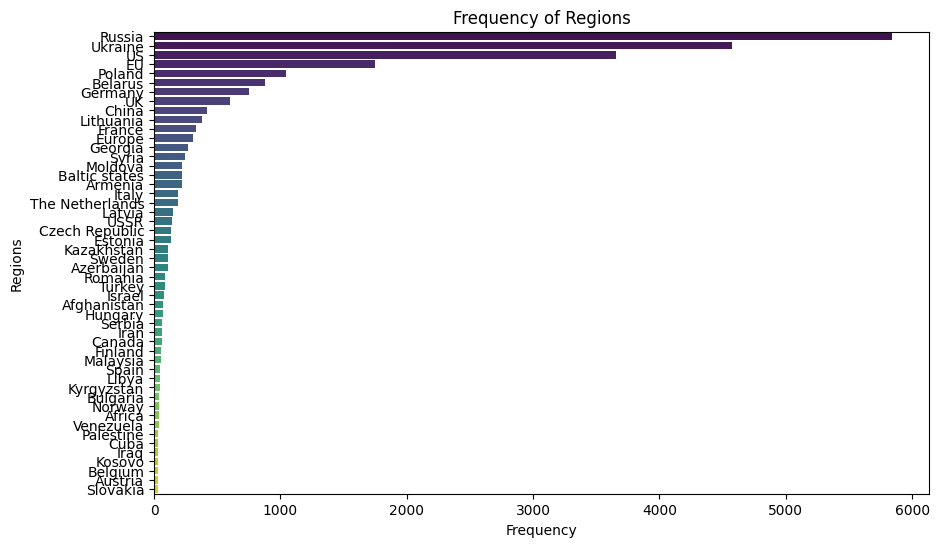

In [ ]:
region_counts = Counter([region.strip() for sublist in df_fake['regions'].str.split(',') for region in sublist])

# Convert the Counter object to a DataFrame for easier manipulation
region_counts_df = pd.DataFrame.from_dict(region_counts, orient='index').reset_index()
region_counts_df.columns = ['region', 'count']

# Sort the DataFrame by count in descending order
region_counts_df = region_counts_df.sort_values(by='count', ascending=False)
top_50_regions = region_counts_df.head(50)
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='region', data=top_50_regions, palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Regions')
plt.title('Frequency of Regions')
plt.show()

<ipython-input-24-2227f8a63110>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='oglan', data=top_50_lan, palette='viridis')


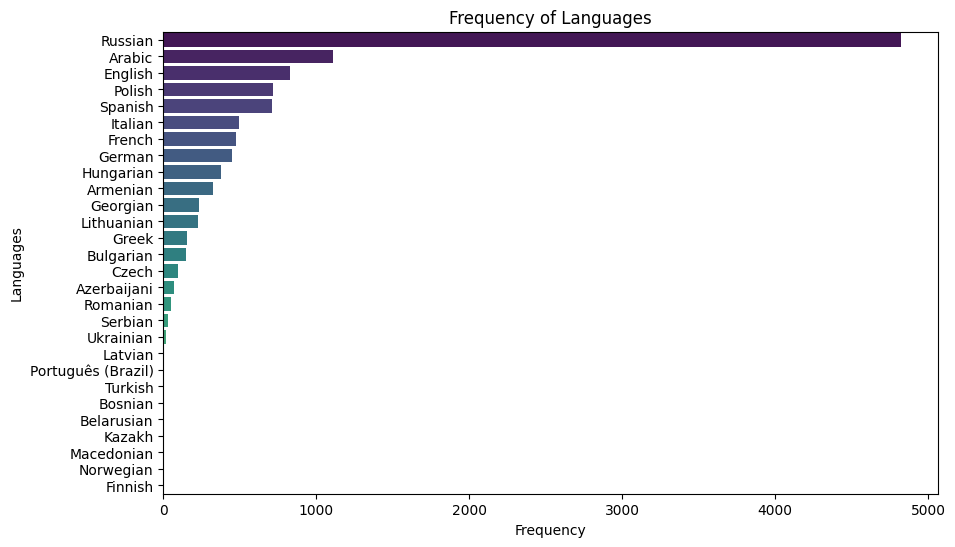

In [ ]:
original_lan = Counter([region.strip() for sublist in df_fake['original_lang'].str.split(',') for region in sublist])
oglan_counts_df = pd.DataFrame.from_dict(original_lan, orient='index').reset_index()
oglan_counts_df.columns = ['oglan', 'count']
oglan_counts_df = oglan_counts_df.sort_values(by='count', ascending=False)
top_50_lan = oglan_counts_df.head(50)

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='oglan', data=top_50_lan, palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Languages')
plt.title('Frequency of Languages')
plt.show()


In [ ]:
#Átlagos szöveghosszúság meghatározása
df_fake['summary_length'] = df_fake['summary'].apply(lambda x: len(str(x)))

average_length = df_fake['summary_length'].mean()

print(f"The average length of the summaries is: {average_length} characters.")

The average length of the summaries is: 330.541457657126 characters.
